In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import datetime as dt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.simplefilter(action="ignore")

%matplotlib inline

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Main Problem
***Central Bureau of Statistics only gather the CPI data up to 82 cities (of 504 city/county in Indonesia)***

**Using KNN algoritm, we assume that most neighbor cities relatively have similiar CPI. However our intial input also has missing values which also need to imputate, espesially in 2000 to 2007. The base data will impute with yoy inflation with KNN too because of unstructured missing values (illustrated with the graph below), this process was done in Excel--easier.**

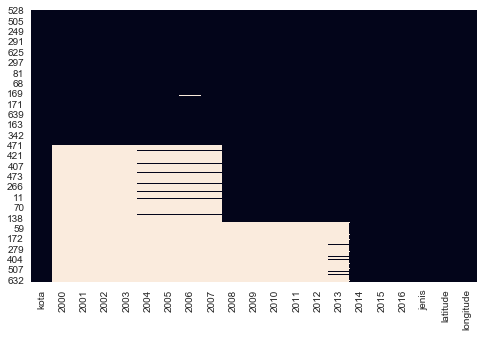

In [3]:
plt.figure(figsize=(8, 5))
sns.heatmap(pd.read_csv("C:/Users/Redata/Downloads/cpikota.csv").sort_values(["2000", "2008"]).isnull(), cbar=False)

In [4]:
#base data (CPI in 82 cities)
data = pd.read_csv("sipdah.csv")

# list of cities want to predict
loc = pd.read_stata("C:/Users/Redata/Downloads/kodeifls.dta").rename(columns={"Latitude__generated_":"latitude", 
                                                                             "Longitude__generated_":"longitude"})
del loc["index"]
loc.drop_duplicates(inplace=True)
loc = loc[["nmkab2014", "nmprov2014", "kabid14", "latitude", "longitude"]]
a = pd.DataFrame(data["kota"].unique())
ma = pd.merge(loc, a, left_on="nmkab2014", right_on=0, how="outer")
ma = ma[["latitude", "longitude", 0, "nmkab2014"]].drop_duplicates()
ma["have CPI Data"] = ma[0].notnull()

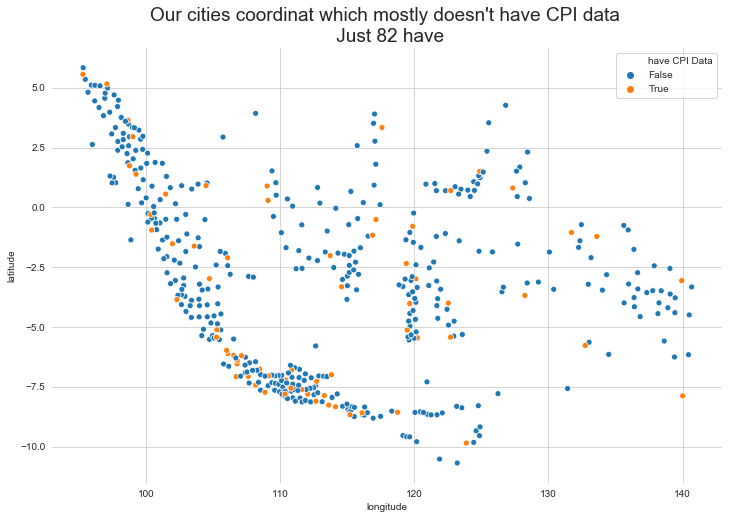

In [5]:
plt.figure(figsize=(12, 8))
sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x="longitude", y="latitude", hue="have CPI Data", data=ma)
s = ma["have CPI Data"].sum()
plt.title(f"Our cities coordinat which mostly doesn't have CPI data \n Just {s} have", size=19)
sns.despine(left = True, bottom = True)
plt.show()

## Another problem
**Our CPI data doesn't have similar base year.Thus, we need to adjust. We decide to choose 2011 as our base year which international org usualy do. The following base year is used according to BPS information:**

| Period        | Base Year           | Source  |
| ------------- |:-------------:| -----:|
| 2000 - 2003      | 1996 | BPS, 2015 (https://bit.ly/cpi00-12)|
| 2004 - 2007     | 2002      |   BPS, 2015 (https://bit.ly/cpi00-12)|
| 2008 - 2013 | 2007      |    BPS, 2015 (https://bit.ly/cpi13-16) |
| 2014 - present | 2012      |   BPS, 2017 (https://bit.ly/cpi13-16)|

*The process also done in excel.*

In [6]:
year = ['2000', "2001", "2002", "2003", "2004", "2005", "2006",'2007',
                         "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016"]
a = data.melt(id_vars=['kota', 'latitude', 'longitude', "jenis"], 
              value_vars=year, 
           value_name="IHK", var_name="year")
a["IHK"] = round(a["IHK"], 2)
a

,kota,latitude,longitude,jenis,year,IHK
0,BANDA ACEH,5.5483,95.3238,Umum,2000,32.58
1,LHOKSEUMAWE,5.1624,97.1024,Umum,2000,39.49
2,SIBOLGA,1.7387,98.7899,Umum,2000,40.72
3,PEMATANG SIANTAR,2.9555,99.0471,Umum,2000,41.83
4,MEDAN,3.6429,98.6761,Umum,2000,39.63
...,...,...,...,...,...,...
11147,CILEGON,-5.9784,106.0260,"Pendidikan, Rekreasi, Dan Olah Raga",2016,151.95
11148,MAUMERE,-8.6246,122.2147,Bahan Makanan,2016,117.87
11149,BIMA,-8.5644,118.7599,Bahan Makanan,2016,147.64
11150,BIMA,-8.5644,118.7599,Sandang,2016,128.20


In [7]:
b = pd.DataFrame()
for i in a.jenis.unique()[:]:
    x = loc.iloc[:, :]
    x["jenis"] = i
    for z in year:
        g = x.iloc[:, :]
        g["year"] = z
        b = pd.concat([b, g])
b.drop_duplicates(inplace=True)

In [8]:
data = pd.merge(a, b, left_on=["kota", "jenis", "year"], 
         right_on=["nmkab2014", "jenis", "year"], how="outer", suffixes=('_x', ''))

In [9]:
satu = data[data["nmkab2014"].notnull()]
dua = data[data["nmkab2014"].isnull()]
dua[["nmkab2014", "latitude", "longitude"]] = dua[["kota","latitude_x","longitude_x"]]
data = pd.concat([satu, dua])
del data["kota"], data["latitude_x"], data["longitude_x"]
data

,jenis,year,IHK,nmkab2014,nmprov2014,kabid14,latitude,longitude
0,Umum,2000,32.58,BANDA ACEH,ACEH,1171.0,5.5620,95.3200
1,Umum,2000,39.49,LHOKSEUMAWE,ACEH,1174.0,5.1624,97.1024
2,Umum,2000,40.72,SIBOLGA,SUMATERA UTARA,1271.0,1.7387,98.7899
3,Umum,2000,41.83,PEMATANG SIANTAR,SUMATERA UTARA,1273.0,2.9555,99.0471
4,Umum,2000,39.63,MEDAN,SUMATERA UTARA,1275.0,3.6429,98.6761
...,...,...,...,...,...,...,...,...
13858,Kesehatan,2016,117.31,MAUMERE,NaN,NaN,-8.6246,122.2147
13860,Kesehatan,2016,118.04,MEULABOH,NaN,NaN,4.1437,96.1281
13861,Bahan Makanan,2016,126.20,MEULABOH,NaN,NaN,4.1437,96.1281
13862,"Transpor, Komunikasi, Dan Jasa Keuangan",2016,123.36,LUBUKLINGGAU,NaN,NaN,-3.2679,102.8285


In [10]:
#data.to_csv("cpi_indonesia_before_imputation(83cities).csv")
#b = ['BATAM', 'JAKARTA', 'PURWOKERTO', 'SAMPIT', 'SINGARAJA', 'TEMBILAHAN', 'MAUMERE', 'TANJUNG', 'MEULABOH', 'WATAMPONE', 'DUMAI', 'LUBUKLINGGAU', 'TANJUNG PANDAN']
#d = [2171 ,3173, 3302, 6106, 5108, 1403, 5310, 6309, 1107, 7311, 1473, 1674, 1902]

In [11]:
z = data.iloc[:,:]
i = pd.get_dummies(z["jenis"])
z[i.columns] = i

z.sample(3)

,jenis,year,IHK,nmkab2014,nmprov2014,kabid14,latitude,longitude,Bahan Makanan,Kesehatan,"Makanan Jadi, Minuman, Rokok, Dan Tembakau","Pendidikan, Rekreasi, Dan Olah Raga","Perumahan, Air, Listrik, Gas, Dan Bahan Bakar",Sandang,"Transpor, Komunikasi, Dan Jasa Keuangan",Umum
67306,"Transpor, Komunikasi, Dan Jasa Keuangan",2011,NaN,KATINGAN,KALIMANTAN TENGAH,6209.0,-1.8651,113.3736,0,0,0,0,0,0,1,0
26931,Bahan Makanan,2014,NaN,MAYBRAT,PAPUA BARAT,9110.0,-1.3962,132.3506,1,0,0,0,0,0,0,0
9505,"Pendidikan, Rekreasi, Dan Olah Raga",2011,100.0,DUMAI,NaN,NaN,1.8453,101.2403,0,0,0,1,0,0,0,0


## We training the model based on non-null values in sample base

In [12]:
#KNN modeling porcess

#split the data
test1 = z[z["IHK"].isnull()]
train = z[z["IHK"].notnull()]
X_train = train[["latitude", "longitude", "year", "Bahan Makanan", 'Makanan Jadi, Minuman, Rokok, Dan Tembakau',
                 'Pendidikan, Rekreasi, Dan Olah Raga', "Kesehatan",
                 'Perumahan, Air, Listrik, Gas, Dan Bahan Bakar', 'Sandang',
                 'Transpor, Komunikasi, Dan Jasa Keuangan', 'Umum']]
y_train = train["IHK"].astype("str")

#training model
knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean') #nearest = one
knn.fit(X_train, y_train)

#filling the missing CPI use model
X_test = test1[["latitude", "longitude", "year", "Bahan Makanan", 'Makanan Jadi, Minuman, Rokok, Dan Tembakau',
                 'Pendidikan, Rekreasi, Dan Olah Raga', "Kesehatan",
                 'Perumahan, Air, Listrik, Gas, Dan Bahan Bakar', 'Sandang',
                 'Transpor, Komunikasi, Dan Jasa Keuangan', 'Umum']]
y_pred = knn.predict(X_test)
test1["IHK"] = y_pred

#merge them
train_data = pd.concat([train, test1], axis=0)
z["IHK"] = train_data["IHK"]

In [13]:
z = z.iloc[:, :-8].reset_index()
z.sample(5) #ok now we dont have any missing data in our base CPI data

,index,jenis,year,IHK,nmkab2014,nmprov2014,kabid14,latitude,longitude
52206,53974,Kesehatan,2013,103.52,SABANG,ACEH,1172.0,5.8395,95.3376
61015,62783,"Transpor, Komunikasi, Dan Jasa Keuangan",2000,35.69,LEMBATA,NUSA TENGGARA TIMUR,5308.0,-8.3781,123.5451
63693,65461,"Transpor, Komunikasi, Dan Jasa Keuangan",2007,88.57,TANAH DATAR,SUMATERA BARAT,1305.0,-0.4681,100.6516
9217,10558,Bahan Makanan,2012,104.34,MANOKWARI,PAPUA BARAT,9105.0,-1.2159,133.6025
59499,61267,"Pendidikan, Rekreasi, Dan Olah Raga",2013,103.98,MALUKU TENGAH,MALUKU,8103.0,-3.1214,129.2540


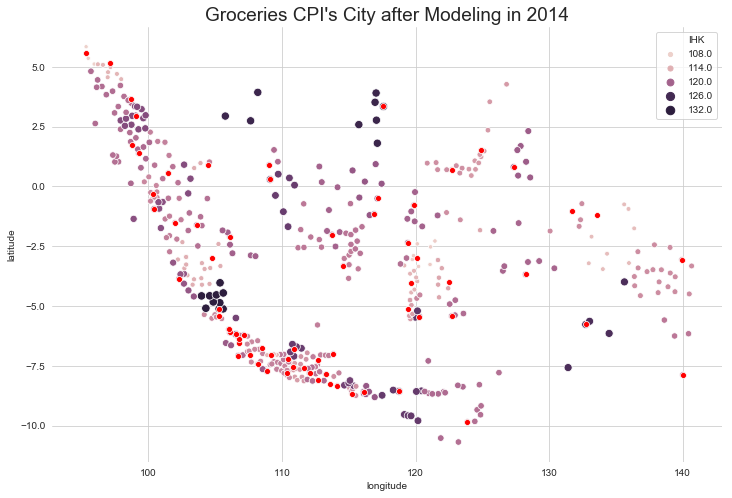

In [14]:
z.IHK = z.IHK.astype("float")
a = z[(z["jenis"] == "Umum") & (z["year"] == "2014")]

plt.figure(figsize=(12, 8))
sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
sns.scatterplot(x="longitude", y="latitude",data= a, size="IHK", hue="IHK")
sns.scatterplot(x="longitude", y="latitude",data=ma[ma["have CPI Data"] == True], color="red")
plt.title("Groceries CPI's City after Modeling in 2014", size=19)
sns.despine(left = True, bottom = True)
plt.legend()
plt.show()

In [15]:
#z.to_csv("cpi indonesia after modelling 2000 - 2016 (511 cities inflation).csv")